# Beacon Time Series, across the transition

Edit selector= below

Look at the beacons with the largest normalized spread.

In [1]:
import math
import pandas as pd
import BQhelper as bq
import matplotlib.pyplot as plt

bq.project = "mlab-sandbox"
# bq.dataset = 'mattmathis'
# bq.UnitTestRunQuery()
# bq.UnitTestWriteQuery()


In [2]:
query="""
SELECT
  a.TestTime,
  client.IP,
  a.MeanThroughputMbps,
  node._instruments
# FROM   `mlab-sandbox.mm_unified_testing.unified_downloads`
FROM `measurement-lab.ndt.unified_downloads`
WHERE client.IP in ( {clientIP} )
AND test_date > '2019-03-01'
ORDER BY TestTime

"""

In [3]:
%matplotlib nbagg
# from matplotlib import interactive
# interactive(True)
plt.ion()

clients = [
    '69.68.23.44', # Max deltaMean
    '96.229.66.58' # Max deltaMax
]


def plotMultiBeacons(clients, columns = 1, width=10):
    clist = '"'+'", "'.join(clients)+'"'
    data=bq.QueryTimestampTimeseries(query, clientIP=clist)
    rows = math.ceil(len(clients) / float(columns))
    figLen = math.ceil(width/float(columns)*rows)  # assume square

    plt.rcParams['figure.figsize'] = [width, figLen]
    for i, client in enumerate(clients):
        cdata = data[data['IP'] == client]
        cur = plt.subplot(rows, columns, i+1)
        plt.title('Beacon: '+client)
        plt.plot(cdata['MeanThroughputMbps'][cdata["_instruments"] == 'web100'], 'b.',
            cdata['MeanThroughputMbps'][cdata["_instruments"] == 'tcpinfo'], 'r.')
    plt.show()
    
    
# plotMultiBeacons(clients, 2, width=10)

In [4]:
# NB: ThousandRandomBeacons4perDay are all domotz tests, which are unspeakably ugly.

listq="""
With

Beacons AS (
SELECT
  clientIP,
  node._Instruments AS vers,
  count(*) AS tests,
  MIN(a.MeanThroughputMbps) AS minTput,
  SUM(a.MeanThroughputMbps) /Count(*) AS meanTput,
  STDDEV(a.MeanThroughputMbps) /Count(*) AS stddevTput,
  MAX(a.MeanThroughputMbps) AS maxTput,
  MIN(a.MinRTT ) AS minMinRTT,
  SUM(a.MinRTT ) /Count(*) AS meanMinRTT,
  MAX(a.MinRTT ) AS maxMinRTT
FROM
  `measurement-lab.ndt.unified_downloads`   -- Remember to test both uploads and downloads
  JOIN `mlab-sandbox.mattmathis.ThousandRandomBeacons4perDay` ON Client.IP = clientIP
WHERE
  test_date BETWEEN '2019-03-01' AND '2020-03-01'
GROUP BY
  node._Instruments, clientIP
),

Paired AS (
SELECT
  NDT5.meanTput - NDTlegacy.meanTput AS delta,
  NDT5.maxTput - NDTlegacy.maxTput AS deltaMax,
  ABS(NDT5.meanTput - NDTlegacy.meanTput ) / SQRT(NDT5.stddevTput*NDTlegacy.stddevTput) AS spread,
  NDT5,
  NDTlegacy,
FROM ( SELECT * FROM Beacons WHERE vers = 'tcpinfo' ) AS NDT5
JOIN ( SELECT * FROM Beacons WHERE vers = 'web100' ) AS NDTlegacy USING ( clientIP )
)

# Choose
SELECT * FROM Paired ORDER BY {selector} LIMIT 30
"""

In [5]:
selector="delta desc"
selector="deltaMax desc"
stepbeacons=bq.QueryDataFrame(listq, selector=selector)

<IPython.core.display.Javascript object>


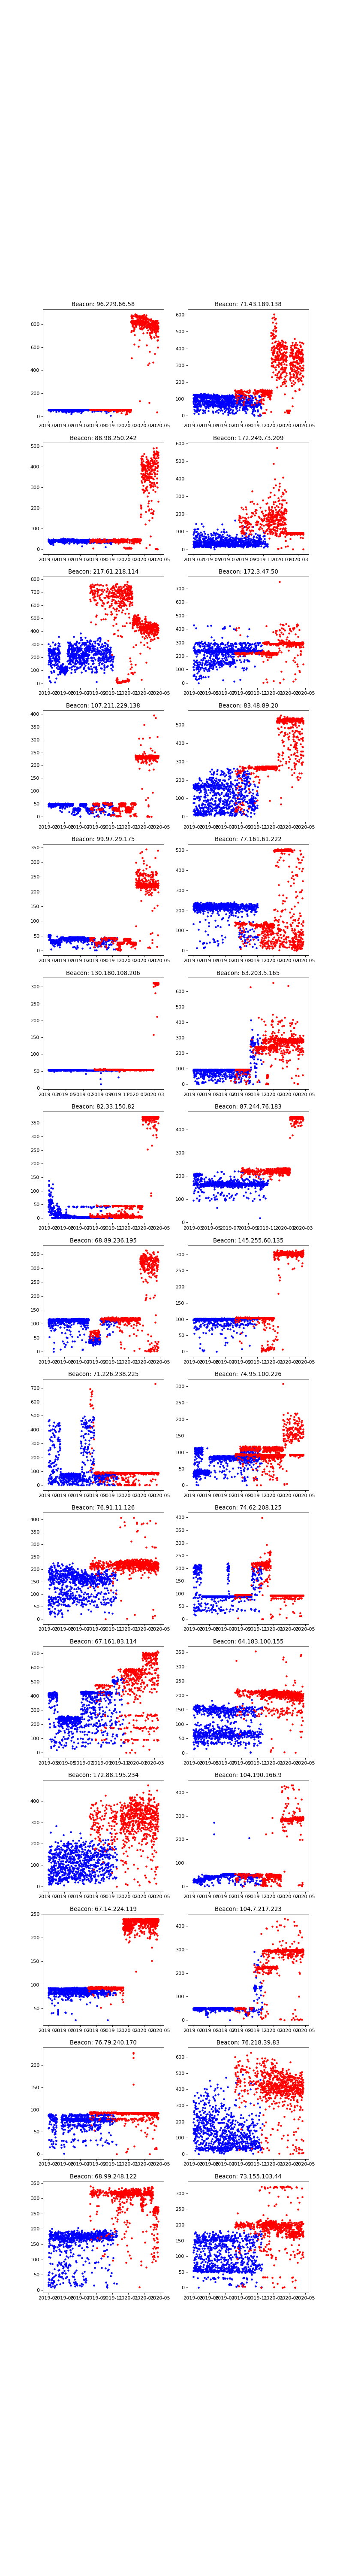

In [6]:
# lame
beacons = []
for t in stepbeacons['NDT5']:
    beacons.append(t['clientIP'])
plotMultiBeacons(beacons, 2, width=10)

In [7]:
# Particularly ugly, 
# plotMultiBeacons(['67.161.83.114'], 1, width=10)
